In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import scipy.stats
import matplotlib.pyplot as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nd/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [58]:
%%javascript

// this adds a shortcut for "run all cells" (not enabled by default) to Ctl+m, r
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [106]:


"""
This Module handles all aspects of student modeling and assessment
Some code remixed from
http://katbailey.github.io/post/gaussian-processes-for-dummies/
^ Great intro article for rolling your own GP
"""
from random import randint
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


class StudentModel():
    """
    This class implements a Gaussian Process, intended to model student vocabulary knowledge
    It uses a kernel based on the distance between two words in ConceptNet as well as a
    phonetic distance heuristic
    """

    def __init__(self):
        #fancy python one-liner to read all string attributes off of a class
        self.curriculum = ['BEE','CHICKEN','MONKEY','RABBIT','ROOSTER','SHEEP','TIGER','SNAKE']

        # these parameters govern the assumed Gaussian noise added to the child's recorded
        # pronunciation assessment
        self.noise_mu = 0
        self.noise_sigma = .2

        self.X_train = [] # These are persistent lists of training data!
        self.Y_train = []

        self.means = [.5] * len(self.curriculum)  # These are the most recent posteriors
        self.variances = [1] * len(self.curriculum) # Together they form the Student Model!

    def init_model(self):
        """
        sets up the GP and kernel
        """


    def get_prior(self, n_samples):
        """
        Samples form a prior distribution over the words
        #See Algorithm 2.1 in Rasmussen and Williams to follow along with this implementation + notation
        """

        # Test data
        # we only care about evaluating the GP at this finite collection of points
        x_test = self.curriculum

        K_ss = self.concept_net_kernel(x_test, x_test) #the Kernel Matrix for the words

        # Get cholesky decomposition (square root) of the
        # covariance matrix
        L = np.linalg.cholesky(K_ss + 1e-15 * np.eye(len(x_test)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior = np.dot(L, np.random.normal(size=(len(x_test), n_samples)))
        return f_prior

    def train_and_compute_posterior(self, new_X_train, new_Y_train):
        """
        Takes in a list of labeled X and labeled Y data points and computes a new posterior
        E.g.
        new_X_train = ['BEE', 'SNAKE', 'TIGER']  # these numbers are the word labels
        new_Y_train = [1, 1, 1] # these numbers correspond to full correct pronunciations

        See Algorithm 2.1 in Rasmussen and Williams to follow along with implementation + notation
        """

        Xtest = self.curriculum  # these numbers are just labels
        for i in range(len(new_X_train)):
            self.X_train.append(new_X_train[i])
            self.Y_train.append(new_Y_train[i])
            
        #compute cov of train set wrt itself + cov of all words wrt all words
        K = self.concept_net_kernel(self.X_train, self.X_train)
        K_ss = self.concept_net_kernel(Xtest, Xtest)

        L = np.linalg.cholesky(K + 0.00005 * np.eye(len(self.X_train)) +
                               ((self.noise_sigma ** 2) * np.eye(len(self.X_train))))

        L_y = np.linalg.solve(L, self.Y_train)
        a = np.linalg.solve(L.T, L_y)

        # Compute the mean at our test points.
        K_s = self.concept_net_kernel(self.X_train, Xtest)
        mu = np.dot(K_s.T, a).reshape(len(self.curriculum), )
        v = np.linalg.solve(L, K_s)

        # we only want the diagonal bc we want to know
        # variance of each variable independent of any others
        variance = np.diag(K_ss - np.dot(v.T, v))
        stdv = np.sqrt(variance)


        self.means = mu
        self.variances = variance
        return self.means, self.variances


    def get_next_best_word(self):
        """
        gives an external caller the next best word to achieve some objective
        Active Learning paradigm should be implemented here!
        """
        return self.curriculum[randint(0, len(self.curriculum) - 1)] #randint is inclusive

    def rbf_kernel(input_a, input_b, length_scale):
        """
        Implements to Radial Basis Function kernel
        """

        sqdist = np.sum(input_a ** 2, 1).reshape(-1, 1) + \
                 np.sum(input_b ** 2, 1) - 2 * np.dot(input_a, input_b.T)
        return np.exp(-.5 * (1 / length_scale) * sqdist)


    def concept_net_kernel(self, word_set_a, word_set_b):
        """
        Implements a conceptnet based covariance matrix
        """
        #k = np.empty((len(word_set_a), len(word_set_b),))
        
        print(word_set_a)
        print(word_set_b)

        #first, validate that these are all words in our curriculum
        for elem in set().union(word_set_a, word_set_b):
            if not elem in self.curriculum:
                raise Exception(elem + ' is not a word in our curriculum')

        k = np.ones((len(word_set_a), len(word_set_b)))
        for i in range(len(word_set_a)):
            for j in range(len(word_set_b)):
                k[i][j] = self.get_word_cov(word_set_a[i], word_set_b[j])

        return k

    def get_word_cov(self, word_a, word_b):
        """
        Currently, just implements a letter counting distance metric.
        Will eventually incorporate conceptnet and other phonetic metrics
        """
        if (word_a == word_b):
            return 1

        score = 0
        for letter_a in word_a:
            if letter_a in word_b:
                score += 1

        for letter_b in word_b:
            if letter_b in word_a:
                score += 1

        ratio = (score / (len(word_a) + len(word_b)))
        return round(ratio, 2)

    def plot_curricular_distro(self):

        n_rows = 2 # needs to be > 1

        # f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), sharex='col', sharey='row', figsize=(15,10))
        f, plts = plt.subplots(n_rows, int(len(self.curriculum) / n_rows), figsize=(15, 10))
        # print(plts)


        left = 0.125  # the left side of the subplots of the figure
        right = 0.9  # the right side of the subplots of the figure
        bottom = 0.4  # the bottom of the subplots of the figure
        top = 0.9  # the top of the subplots of the figure
        wspace = 1.0  # the amount of width reserved for blank space between subplots
        hspace = 0.2  # the amount of height reserved for white space between subplots

        for i in range(len(self.curriculum)):
            row_index = int(i / (len(self.curriculum) * .5))
            col_index = int(i % (len(self.curriculum) / n_rows))
            plts[row_index][col_index].set_xlim([-3, 3])
            plts[row_index][col_index].set_ylim([-1.5, 1.5])

            #data = f_post[:][i]
            print(self.curriculum[i])
            #print(np.mean(data))
            #print(np.var(data))
            print(self.means[i])
            print(self.variances[i])
            # plts[row_index][col_index].scatter(data, np.zeros(n_samples))

            x = np.linspace(-3, 3, 50)
            plts[row_index][col_index].plot(x, scipy.stats.norm.pdf(x, self.means[i], self.variances[i]))
            plts[row_index][col_index].set_title(
                self.curriculum[i] + ": u= " + str(round(self.means[i], 2)) + ", var= " + str(
                    round(self.variances[i], 2)))

        plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
        plt.draw()
        plt.show()




['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']


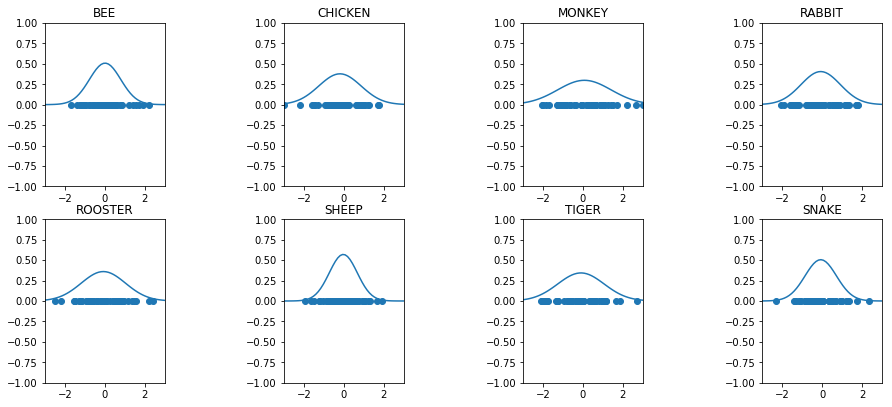

In [95]:
msm = StudentModel()

test_space_size = len(msm.curriculum)
n_samples = 50
n_rows = 2

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.4   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 1.0   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

f_prior = msm.get_prior(n_samples)
#print(f_prior)

#f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), sharex='col', sharey='row', figsize=(15,10))
f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), figsize=(15,10))
#print(plts)

for i in range(test_space_size):
    row_index = int(i / (test_space_size * .5))
    col_index = int(i % (test_space_size / n_rows))
    plts[row_index][col_index].set_xlim([-3, 3])
    plts[row_index][col_index].set_ylim([-1, 1])
    
    data = f_prior[:][i]
    plts[row_index][col_index].scatter(data, np.zeros(n_samples))
    
    variance = 1
    x = np.linspace(-3,3, 50)
    plts[row_index][col_index].plot(x,mlab.normpdf(x, np.mean(data), np.var(data)))    
    plts[row_index][col_index].set_title(msm.curriculum[i])
    
subplots_adjust(left, bottom, right, top, wspace, hspace)

#     plts[0][0].set_title('Sharing x per column, y per row')
#     plts[0][1].scatter(x, y)
#     plts[1][0].scatter(x, 2 * y ** 2 - 1, color='r')
#     plts[1][1].plot(x, 2 * y ** 2 - 1, color='r')

['BEE', 'SNAKE', 'TIGER']
['BEE', 'SNAKE', 'TIGER']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'SNAKE', 'TIGER']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
BEE
0.980791554068
0.0380627730303
CHICKEN
0.691224718879
0.702445164218
MONKEY
0.639668341537
0.689647174823
RABBIT
0.639668341537
0.689647174823
ROOSTER
0.743980499963
0.628348320362
SHEEP
0.767363627726
0.637672800637
TIGER
0.973589137095
0.0382619337277
SNAKE
0.973589137095
0.0382619337277


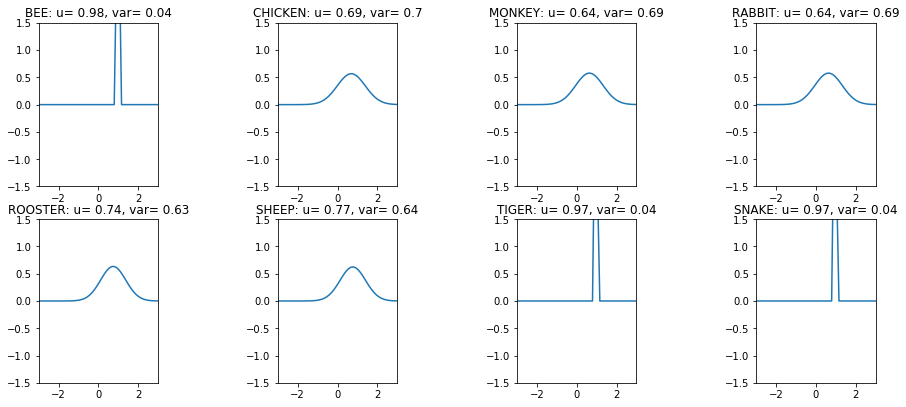

['BEE', 'SNAKE', 'TIGER', 'BEE', 'SNAKE', 'TIGER']
['BEE', 'SNAKE', 'TIGER', 'BEE', 'SNAKE', 'TIGER']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'SNAKE', 'TIGER', 'BEE', 'SNAKE', 'TIGER']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
BEE
0.49518027375
0.0195130681048
CHICKEN
0.350140766951
0.697851663076
MONKEY
0.323875170352
0.684683694904
RABBIT
0.323875170352
0.684683694904
ROOSTER
0.376929695167
0.622162883104
SHEEP
0.388232010009
0.633003693689
TIGER
0.493294396406
0.0195664897015
SNAKE
0.493294396406
0.0195664897015


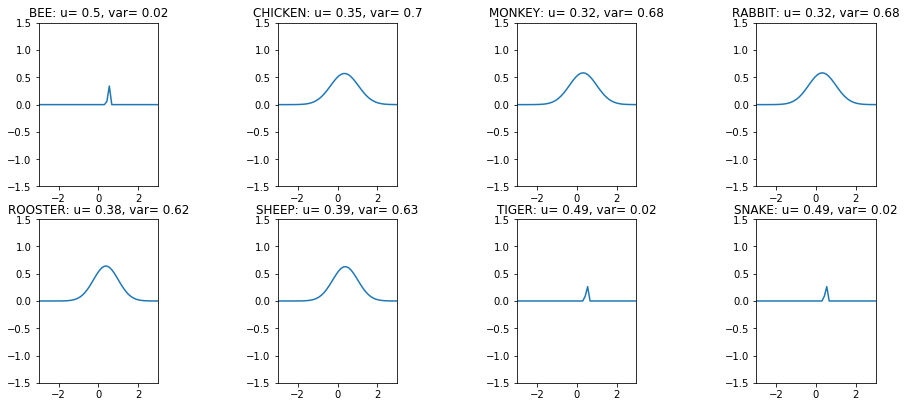

In [107]:
msm = StudentModel()
Xtrain = ['BEE', 'SNAKE', 'TIGER'] # these numbers are just labels
Ytrain = [1,1,1] # these numbers correspond to 'Correct' demonstrations

msm.train_and_compute_posterior(Xtrain, Ytrain)
msm.plot_curricular_distro()

Xtrain = ['BEE', 'SNAKE', 'TIGER'] # these numbers are just labels
Ytrain = [0,0,0] # these numbers correspond to 'Correct' demonstrations

msm.train_and_compute_posterior(Xtrain, Ytrain)
msm.plot_curricular_distro()

['BEE', 'SNAKE', 'TIGER']
['BEE', 'SNAKE', 'TIGER']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
['BEE', 'SNAKE', 'TIGER']
['BEE', 'CHICKEN', 'MONKEY', 'RABBIT', 'ROOSTER', 'SHEEP', 'TIGER', 'SNAKE']
[ 0.98079155  0.69122472  0.63966834  0.63966834  0.7439805   0.76736363
  0.97358914  0.97358914]
[ 0.19509683  0.83812002  0.83044998  0.83044998  0.79268425  0.79854418
  0.19560658  0.19560658]
BEE
0.980791554068
0.195096829883
CHICKEN
0.691224718879
0.838120017789
MONKEY
0.639668341537
0.830449983336
RABBIT
0.639668341537
0.830449983336
ROOSTER
0.743980499963
0.792684250104
SHEEP
0.767363627726
0.798544175758
TIGER
0.973589137095
0.195606578948
SNAKE
0.973589137095
0.195606578948


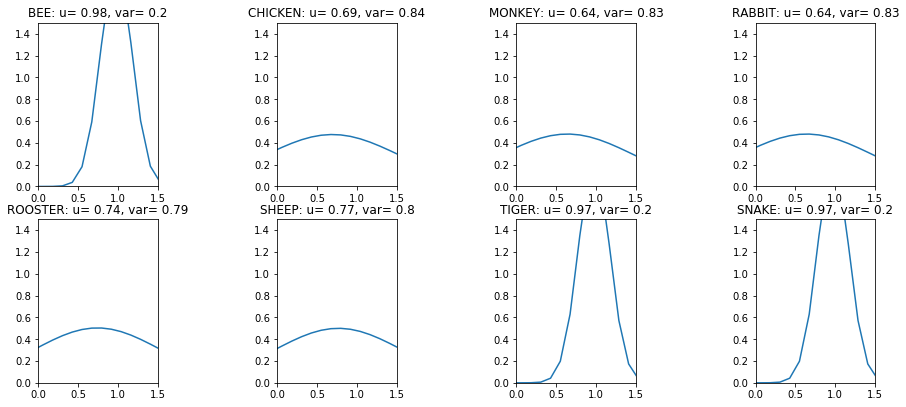

In [75]:

###################
#See Algorithm 2.1 in Rasmussen and Williams to follow along with this implementation + notation
####################


Xtrain = ['BEE', 'SNAKE', 'TIGER'] # these numbers are just labels
Ytrain = [1,1,1] # these numbers correspond to 'Correct' demonstrations

noise_mu, noise_sigma = 0, .2

Xtest = msm.curriculum # these numbers are just labels

# After each re-training, we do these steps
K = msm.concept_net_kernel(Xtrain, Xtrain)
K_ss = msm.concept_net_kernel(Xtest, Xtest)

L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)) + ((noise_sigma ** 2)*np.eye(len(Xtrain))))
L_y = np.linalg.solve(L, Ytrain)
a = np.linalg.solve(L.T, L_y)

# Compute the mean at our test points.
K_s = msm.concept_net_kernel(Xtrain, Xtest)
mu = np.dot(K_s.T, a).reshape(len(msm.curriculum),)
v = np.linalg.solve(L, K_s)

#we only want the diagonal because we want to know the variance of each variable independent of any others
variance = np.diag(K_ss - np.dot(v.T, v))
stdv = np.sqrt(variance)



# Compute the standard deviation so we can plot it
#s2 = np.diag(cov_ss) - np.sum(Lk**2, axis=0)
#stdv = np.sqrt(s2)

print(mu)
print(stdv)

# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(test_space_size) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(test_space_size, n_samples)))

#f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), sharex='col', sharey='row', figsize=(15,10))
f, plts = plt.subplots(n_rows, int(test_space_size / n_rows), figsize=(15,10))
#print(plts)

for i in range(test_space_size):
    row_index = int(i / (test_space_size * .5))
    col_index = int(i % (test_space_size / n_rows))
    plts[row_index][col_index].set_xlim([0, 1.5])
    plts[row_index][col_index].set_ylim([0, 1.5])
    
    data = f_post[:][i]
    print(msm.curriculum[i])
    print(mu[i])
    print(stdv[i])
    #plts[row_index][col_index].scatter(data, np.zeros(n_samples))
    
    variance = 1
    x = np.linspace(-3,3, 50)
    plts[row_index][col_index].plot(x, scipy.stats.norm.pdf(x, mu[i], stdv[i]))
    plts[row_index][col_index].set_title(msm.curriculum[i] + ": u= " + str(round(mu[i], 2)) + ", var= " + str(round(stdv[i], 2)))
    
subplots_adjust(left, bottom, right, top, wspace, hspace)
